# Bayesian optimization - 1D toy example for NPA reading group

### Plot auxiliar functions

We first define auxiliar functions that will be used to plot

In [1]:
#Plot functions

def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1) 
    plt.plot(X, Y, 'y--', lw=1, label='Noise-free objective')
    plt.plot(X, mu, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()    
        
def plot_convergence(X_sample, Y_sample, n_init=2):
    plt.figure(figsize=(12, 3))

    x = X_sample[n_init:].ravel()
    y = Y_sample[n_init:].ravel()
    r = range(1, len(x)+1)
    
    x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
    y_max_watermark = np.maximum.accumulate(y)
    
    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, 'bo-')
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.title('Distance between consecutive x\'s')

    plt.subplot(1, 2, 2)
    plt.plot(r, y_max_watermark, 'ro-')
    plt.xlabel('Iteration')
    plt.ylabel('Best Y')
    plt.title('Value of best selected sample')

## Implementation with NumPy and SciPy

In this section, we will implement the acquisition function and its optimization in plain NumPy and SciPy and use scikit-learn for the Gaussian process implementation. Although we have an analytical expression of the optimization objective $f$ in the following example, we treat is as black box and iteratively approximate it with a Gaussian process during Bayesian optimization. Furthermore, samples drawn from the objective function are noisy and the noise level is given by the noise variable. Optimization is done within given bounds. We also assume that there exist two initial samples in X_init and Y_init.

In [2]:
import numpy as np

%matplotlib inline

bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

### Noise-free objective function

The following plot shows the noise-free objective function, the amount of noise by plotting a large number of samples and the two initial samples.

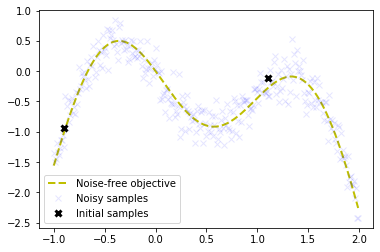

In [3]:
import matplotlib.pyplot as plt

# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

### Acquisition function

Proposing sampling points in the search space is done by acquisition functions. They trade off exploitation and exploration. Exploitation means sampling where the surrogate model predicts a high objective and exploration means sampling at locations where the prediction uncertainty is high. Both correspond to high acquisition function values and the goal is to maximize the acquisition function to determine the next sampling point.

More formally, the objective function $f$ will be sampled at $\mathbf{x}_t = \operatorname{argmax}_{\mathbf{x}} u(\mathbf{x} \lvert \mathcal{D}_{1:t-1})$ where $u$ is the acquisition function and $\mathcal{D}_{1:t-1} = {(\mathbf{x}_1, y_1),…,(\mathbf{x}_{t-1}, y_{t-1})}$ are the $t−1$ samples drawn from f so far. Popular acquisition functions are maximum probability of improvement (MPI) and expected improvement (EI). In the following, we will use the expected improvement (EI) which is most widely used and described further below.

#### Expected improvement

Expected improvement is defined as

$\operatorname{EI}(\mathbf{x}) = \mathbb{E}\max(f(\mathbf{x}) - f(\mathbf{x}^+), 0)\tag{1}$

where $f(x^+)$ is the value of the best sample so far and $x^+$ is the location of that sample i.e. $\mathbf{x}^+ = \operatorname{argmax}_{\mathbf{x}_i \in \mathbf{x}_{1:t}} f(\mathbf{x}_i)$. The expected improvement can be evaluated analytically under the GP model:

$\operatorname{EI}(\mathbf{x}) =
\begin{cases}
(\mu(\mathbf{x}) - f(\mathbf{x}^+) - \xi)\Phi(Z) + \sigma(\mathbf{x})\phi(Z)  &\text{if}\ \sigma(\mathbf{x}) > 0 \\
0 & \text{if}\ \sigma(\mathbf{x}) = 0
\end{cases}\tag{2}$

With

$$Z =
\begin{cases}
\frac{\mu(\mathbf{x}) - f(\mathbf{x}^+) - \xi}{\sigma(\mathbf{x})} &\text{if}\ \sigma(\mathbf{x}) > 0 \\
0 & \text{if}\ \sigma(\mathbf{x}) = 0
\end{cases}$$

where $\mu(x)$ and $\sigma(x)$ are the mean and the standard deviation of the GP posterior predictive at $x$, respectively. $\Phi$ and $\phi$ are the CDF and PDF of the standard normal distribution, respectively. The first summation term in Equation (2) is the exploitation term and second summation term is the exploration term.

Parameter $\xi$ in Equation (2) determines the amount of exploration during optimization and higher $\xi$ values lead to more exploration. In other words, with increasing $\xi$ values, the importance of improvements predicted by the GP posterior mean $\mu(x)$ decreases relative to the importance of potential improvements in regions of high prediction uncertainty, represented by large $\sigma(x)$ values. A recommended default value for $\xi$ is 0.01.

With this minimum of theory we can start implementing Bayesian optimization. The next section shows a basic implementation with plain NumPy and SciPy, later sections demonstrate how to use existing libraries. Finally, Bayesian optimization is used to tune the hyperparameters of a tree-based regression model.

Goal is to find the global optimum on the left in a small number of steps. The next step is to implement the acquisition function defined in Equation (2) as expected_improvement function.

In [4]:
from scipy.stats import norm

def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

We also need a function that proposes the next sampling point by computing the location of the acquisition function maximum. Optimization is restarted n_restarts times to avoid local optima.

In [5]:
from scipy.optimize import minimize

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.


    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

Now we have all components needed to run Bayesian optimization with the algorithm outlined above. The Gaussian process in the following example is configured with a Matérn kernel which is a generalization of the squared exponential kernel or RBF kernel. The known noise level is configured with the alpha parameter.

Bayesian optimization runs for 10 iterations. In each iteration, a row with two plots is produced. The left plot shows the noise-free objective function, the surrogate function which is the GP posterior predictive mean, the 95% confidence interval of the mean and the noisy samples obtained from the objective function so far. The right plot shows the acquisition function. The vertical dashed line in both plots shows the proposed sampling point for the next iteration which corresponds to the maximum of the acquisition function.

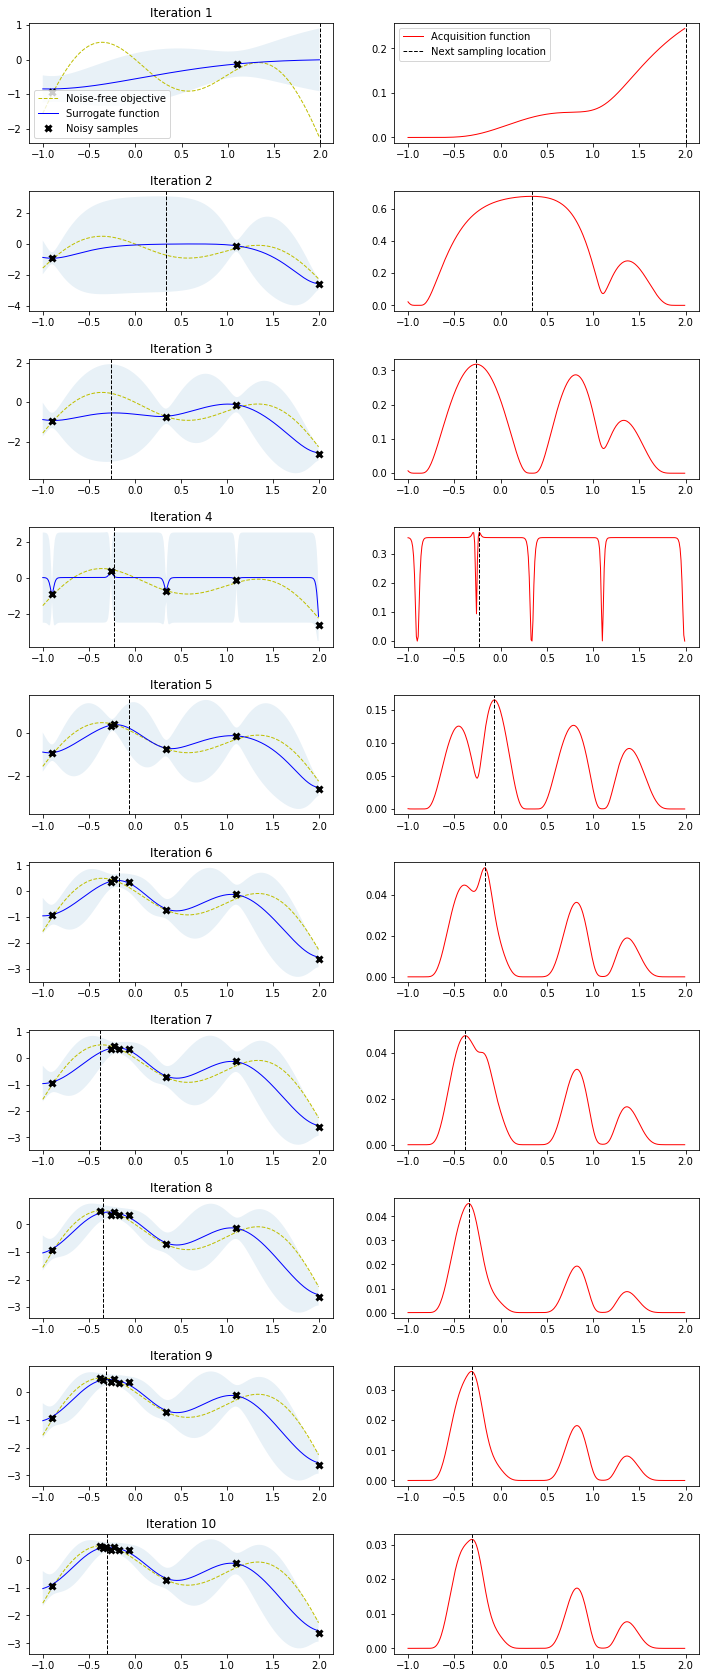

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

bounds = np.array([[-1.0, 2.0]])
noise = 0.2

# Gaussian process with Matern kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

Note how the two initial samples initially drive search into the direction of the local maximum on the right side but exploration allows the algorithm to escape from that local optimum and find the global optimum on the left side. Also note how sampling point proposals often fall within regions of high uncertainty (exploration) and are not only driven by the highest surrogate function values (exploitation).

A convergence plot reveals how many iterations are needed the find a maximum and if the sampling point proposals stay around that maximum i.e. converge to small proposal differences between consecutive steps.

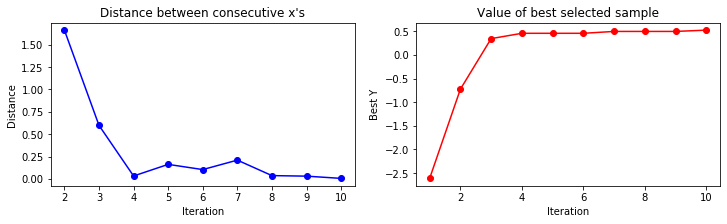

In [7]:
plot_convergence(X_sample, Y_sample)

## Reference

[1]. https://machinelearningmastery.com/what-is-bayesian-optimization/

[2]. http://krasserm.github.io/2018/03/21/bayesian-optimization/

[3]. Frazier, P. I. (2018). 'A tutorial on Bayesian optimization'. arXiv preprint arXiv:1807.02811.

[4]. Brochu, E., Cora, V. M., & De Freitas, N. (2010). 'A tutorial on Bayesian optimization of expensive cost functions, with application to active user modeling and hierarchical reinforcement learning'. arXiv preprint arXiv:1012.2599.

[5]. Maggi, L., Valcarce, A., \& Hoydis, J. (2021). 'Bayesian optimization for radio resource management: Open loop power control'. IEEE Journal on Selected Areas in Communications, 39(7), 1858-1871

[6]. Gelbart, M. A., Snoek, J., \& Adams, R. P. (2014). 'Bayesian optimization with unknown constraints'. arXiv preprint arXiv:1403.5607.

[7]. Hoffman, M., Brochu, E., \& De Freitas, N. (2011, July). 'Portfolio Allocation for Bayesian Optimization'. In UAI (pp. 327-336).

[8]. Vrugt, J. A., Hopmans, J. W., \& Šimunek, J. (2001). 'Calibration of a two‐dimensional root water uptake model'. Soil Science Society of America Journal, 65(4), 1027-1037.

[9]. Kirthevasan Kandasamy, Jeff G. Schneider, \& Barnabs Pczos. 'High Dimensional Bayesian Optimisation and Bandits via Additive Models'. In ICML, volume 37, pages 295–304, 2015

[10]. Li, C., Gupta, S., Rana, S., Nguyen, V., Venkatesh, S., \& Shilton, A. (2018). 'High dimensional Bayesian optimization using dropout'. arXiv preprint arXiv:1802.05400.

[11]. Wang, Z., Hutter, F., Zoghi, M., Matheson, D., \& de Freitas,
N. 'Bayesian optimization in a billion dimensions via random
embeddings'. Journal of Artificial Intelligence Research, 55:
361–387

[12]. Nayebi, A., Munteanu, A., \& Poloczek, M. (2019, May). 'A framework for Bayesian optimization in embedded subspaces'. In International Conference on Machine Learning (pp. 4752-4761). PMLR.

[13]. Jaquier, N., \& Rozo, L. (2020). 'High-dimensional Bayesian optimization via nested Riemannian manifolds'. Advances in Neural Information Processing Systems, 33, 20939-20951.

[14]. Daverman, R. J. (1978). 'Embeddings of $(n-1)$-spheres in Euclidean $n$-space'. Bulletin of the American Mathematical Society, 84(3), 377-405.

[15]. Snoek, J., Larochelle, H., \& Adams, R. P. (2012). 'Practical Bayesian optimization of machine learning algorithms'. Advances in neural Information Processing Systems, volume 25, pages 2951–2959. Curran Associates, Inc.

[16]. Lee, E. H., Perrone, V., Archambeau, C., & Seeger, M. (2020b). 'Cost-aware bayesian optimization'.
arXiv preprint arXiv:2003.10870.

[17]. Lee, E. H., Eriksson, D., Perrone, V., & Seeger, M. (2021). 'A nonmyopic approach to costconstrained Bayesian optimization'. In Conference on Uncertainty in Artificial Intelligence.

[18]. Ziyu Wang, Masrour Zoghi, Frank Hutter, David Matheson, \& Nando De Freitas. 'Bayesian optimization in high dimensions via random embeddings'. In IJCAI, pages 1778–1784, 2013.

[19]. Hong Qian, Yi-Qi Hu, \& Yang Yu. 'Derivative-free optimization of high-dimensional nonconvex functions by sequential random embeddings'. In Proceedings of the 25th International Joint Conference on Artificial Intelligence, 2016.
